In [2]:
import warnings
warnings.filterwarnings('ignore')

## Loading Dataset ##

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from tqdm import tqdm
import time

# Read JSON file and convert to pandas DataFrame
def load_dataset(directory: str = "raw_datasets") -> dict:
        """Load raw JSON datasets from the specified directory and combine by action types
        
        Args:
            directory (str): Path to the directory containing JSON dataset files
            
        Returns:
            dict: Dictionary containing combined datasets by action types
        """
        if not os.path.exists(directory):
            raise FileNotFoundError(f"Directory '{directory}' not found!")
            
        # Get all JSON files in the directory
        data_files = [f for f in os.listdir(directory) if f.endswith('.json')]
        
        if not data_files:
            raise ValueError("No JSON files found in the directory!")
            
        # Initialize combined data dictionary
        combined_data = {
            "deposits": [],
            "withdraws": [],
            "borrows": [],
            "repays": [],
            "liquidates": []
        }
        
        # Create progress bar for loading files
        with tqdm(data_files, desc="Loading JSON datasets", unit="file") as pbar:
            for file in pbar:
                file_path = os.path.join(directory, file)
                try:
                    # Update progress bar description
                    pbar.set_description(f"Processing {file}")
                    
                    # Read the JSON file
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                    
                    # Combine data by action type
                    for action_type in combined_data.keys():
                        if action_type in data:
                            combined_data[action_type].extend(data[action_type])
                            pbar.set_postfix({
                                f"{action_type}": len(combined_data[action_type])
                            })
                    
                except Exception as e:
                    print(f"Error loading {file}: {str(e)}")
                    continue
        
        # Print summary of loaded data
        print("\nSuccessfully loaded and combined datasets!")
        for action_type, data in combined_data.items():
            print(f"- {action_type}: {len(data)} records")
            
        return combined_data
dataset = load_dataset()

Processing compoundV2_transactions_ethereum_chunk_2.json: 100%|██████████| 3/3 [00:01<00:00,  2.68file/s, liquidates=20737]


Successfully loaded and combined datasets!
- deposits: 30000 records
- withdraws: 30000 records
- borrows: 30000 records
- repays: 30000 records
- liquidates: 20737 records


## Exploratory analysis ##

hash and id: Transaction Uniqueness
The hash field represents the transaction hash on the Ethereum blockchain. It is a unique fingerprint for each interaction, ensuring immutability and traceability. No two transactions share the same hash.

The id field (which often duplicates the hash) may serve as an internal identifier used by the data ingestion system or API.

In [8]:
unique_wallets = set()
for action_type, records in dataset.items():
    for entry in records:
        if 'account' in entry:
            unique_wallets.add(entry['account']['id'])

print(f"Total unique wallets: {len(unique_wallets)}")

# SO this is an unique identifier for each event 
# So no patterns so we can't use it for any analysis
unique_event_ids = set()
unique_event_hashes = set()
for action_type, records in dataset.items():
    for entry in records:
        if 'id' in entry:
            unique_event_ids.add(entry['id'])
        if 'hash' in entry:
            unique_event_hashes.add(entry['hash'])

print(f"Total unique event ids: {len(unique_event_ids)}")
print(f"Total unique event hashes: {len(unique_event_hashes)}")

print(f"{len(unique_wallets)} people have made {len(unique_event_ids)} transactions, which is {len(unique_event_ids)/len(unique_wallets)} transactions per person")


Total unique wallets: 13484
Total unique event ids: 140737
Total unique event hashes: 130110
13484 people have made 140737 transactions, which is 10.43733313556808 transactions per person


Token-specific behaviors differ drastically. Lending USDC or DAI is low-risk; borrowing obscure or volatile assets could indicate risk-seeking behavior.

Asset ID allows us to map each token to a heuristic risk tier, which is then used in the token quality scoring logic.

Some bots or malicious actors may exploit lesser-known tokens — tracking them through their asset.id is the only reliable method.

In [9]:
from collections import Counter

# Extract all asset ids from the deposits
asset_ids_01 = [entry['asset']['id'] for entry in dataset['deposits'] if 'asset' in entry and 'id' in entry['asset']]
asset_ids_02 = [entry['asset']['id'] for entry in dataset['withdraws'] if 'asset' in entry and 'id' in entry['asset']]
asset_ids_03 = [entry['asset']['id'] for entry in dataset['borrows'] if 'asset' in entry and 'id' in entry['asset']]
asset_ids_04 = [entry['asset']['id'] for entry in dataset['repays'] if 'asset' in entry and 'id' in entry['asset']]
asset_ids_05 = [entry['asset']['id'] for entry in dataset['liquidates'] if 'asset' in entry and 'id' in entry['asset']]
# Count occurrences of each asset id
asset_id_counts = Counter(asset_ids_01)
asset_id_counts_02 = Counter(asset_ids_02)
asset_id_counts_03 = Counter(asset_ids_03)
asset_id_counts_04 = Counter(asset_ids_04)
asset_id_counts_05 = Counter(asset_ids_05)
# Print the counts
for asset_id, count in asset_id_counts.items():
    print(f"Asset ID: {asset_id} - Count: {count}")
print("deposits","="*100)
for asset_id, count in asset_id_counts_02.items():
    print(f"Asset ID: {asset_id} - Count: {count}")
print("withdraws","="*100)
for asset_id, count in asset_id_counts_03.items():
    print(f"Asset ID: {asset_id} - Count: {count}")
print("borrows","="*100)
for asset_id, count in asset_id_counts_04.items():
    print(f"Asset ID: {asset_id} - Count: {count}")
print("repays","="*100)
for asset_id, count in asset_id_counts_05.items():
    print(f"Asset ID: {asset_id} - Count: {count}")
print("liquidates","="*100)



Asset ID: 0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee - Count: 6463
Asset ID: 0x0d8775f648430679a709e98d2b0cb6250d2887ef - Count: 1145
Asset ID: 0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359 - Count: 17892
Asset ID: 0x1985365e9f78359a9b6ad760e32412f4a445e862 - Count: 264
Asset ID: 0xe41d2489571d322189246dafa5ebde1f4699f498 - Count: 642
Asset ID: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48 - Count: 3331
Asset ID: 0x2260fac5e5542a773aa44fbcfedf7c193bc2c599 - Count: 263
deposits ====================================================================================================
Asset ID: 0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee - Count: 6954
Asset ID: 0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359 - Count: 16941
Asset ID: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48 - Count: 4119
Asset ID: 0x0d8775f648430679a709e98d2b0cb6250d2887ef - Count: 823
Asset ID: 0x1985365e9f78359a9b6ad760e32412f4a445e862 - Count: 257
Asset ID: 0xe41d2489571d322189246dafa5ebde1f4699f498 - Count: 550
Asset ID: 0x2260fac5e55

In [10]:
dfs = []
for action_type, records in dataset.items():
    if records:
        df = pd.json_normalize(records)
        df['action_type'] = action_type
        dfs.append(df)
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.head()


,amount,amountUSD,hash,id,timestamp,account.id,asset.id,asset.symbol,action_type,liquidatee.id,liquidator.id
0,10000000000000000,1.78010000000000014408,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,1557193282,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,deposits,NaN,NaN
1,80000000000000000,14.24080000000000115264,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,1557193511,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,deposits,NaN,NaN
2,4582920657824222640301,1562.320140205329756474017145956277,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,1557195125,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x0d8775f648430679a709e98d2b0cb6250d2887ef,BAT,deposits,NaN,NaN
3,4013962940167102266494,4013.962940167102266494,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,1557195125,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,DAI,deposits,NaN,NaN
4,9990000000000000000,1775.4727500000001641357,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,1557196912,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,deposits,NaN,NaN


account.id: Wallet Identifier
This field identifies the wallet address (EOA or smart contract) that initiated the action (e.g., deposit, borrow, repay).

It is used as the primary grouping key when building wallet-level features and assigning credit scores.

Every behavioral pattern — repayment rate, liquidation frequency, token preferences — is aggregated by this ID.

In [13]:
for action in dataset:
    print(action, '\n',dataset[action][0])

deposits 
 {'account': {'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be442708'}, 'amount': '10000000000000000', 'amountUSD': '1.78010000000000014408', 'asset': {'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee', 'symbol': 'ETH'}, 'hash': '0xa1b27194b198762eaa631564fea76008b363c157a1ccf9df5f1338b7c566fd3a', 'id': '0xa1b27194b198762eaa631564fea76008b363c157a1ccf9df5f1338b7c566fd3a-69', 'timestamp': '1557193282'}
withdraws 
 {'account': {'id': '0xa9ee140bfe20a7a5f9e170c6e89ec4b0906d297d'}, 'amount': '10000099227753878', 'amountUSD': '1.670143911178463392349813005223923', 'asset': {'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee', 'symbol': 'ETH'}, 'hash': '0x2cd6851aaaff508ed416f4d562fd2ac6f75e34d069a94e65eb3239d7e05181db', 'id': '0x2cd6851aaaff508ed416f4d562fd2ac6f75e34d069a94e65eb3239d7e05181db-79', 'timestamp': '1557289469'}
borrows 
 {'account': {'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be442708'}, 'amount': '100000000000000000000', 'amountUSD': '27.7974340750000025', 'asset': {'id': '

## PreProcessing ##
- The function transforms unstructured JSON data into a consistent tabular format with a standardized set of columns across all transaction types, allowing for uniform analysis regardless of transaction category.
- The function explicitly handles entity identification by creating a consistent 'wallet' identifier column, particularly addressing the special case of liquidation events where the liquidatee (not the transaction initiator) is the wallet of interest for credit scoring.
- By converting Unix timestamps to datetime objects and sorting all events chronologically, the function creates a proper temporal dimension essential for analyzing behavioral patterns and time-dependent features.
- Numeric values (amounts and USD values) are properly converted to ensure mathematical operations will work correctly, while preserving the original meaning of the data.
- The function explicitly identifies and handles missing fields by ensuring all expected columns exist across all transaction types, which prevents downstream analysis errors and creates a complete dataset suitable for feature engineering.

In [59]:
def preprocess_data_2(raw_data: dict):
    """
    Convert raw JSON data into pandas DataFrames and perform preprocessing
    while preserving all original columns and handling missing values properly
    """
    if raw_data is None:
        raise ValueError("Data has not been loaded. Call load_data() first.")
        
    print("Preprocessing data...")
    start_time = time.time()
    
    # Define all possible columns we expect to see (excluding liquidatee and liquidator)
    all_columns = [
        'amount', 'amountUSD', 'hash', 'id', 'timestamp',
        'account.id', 'asset.id', 'asset.symbol', 'wallet',
        'action_type'
    ]
    
    # Convert each action type to a DataFrame
    action_dfs = {}
    preprocess_pbar = tqdm(raw_data.items(), desc="Preprocessing action types", unit="type")
    
    for action_type, data in preprocess_pbar:
        if data:  # Only process if there's data
            preprocess_pbar.set_description(f"Processing {action_type}")
            
            # Convert to DataFrame while preserving all columns
            df = pd.json_normalize(data)
            
            # Ensure all expected columns exist
            for col in all_columns:
                if col not in df.columns:
                    df[col] = None
            
            # Convert timestamp to datetime if present
            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='s')
            
            # Handle wallet address based on action type
            if action_type == 'liquidates':
                # For liquidations, use liquidatee.id as the wallet
                df['wallet'] = df['liquidatee.id']
                df['account.id'] = df['liquidatee.id']
            else:
                df['wallet'] = df['account.id']
            
            # Convert amounts to numeric values if present
            for col in ['amount', 'amountUSD']:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Add action type as a column
            df['action_type'] = action_type
            
            # Reorder columns to ensure consistency
            df = df[all_columns]
            
            action_dfs[action_type] = df
    
    # Create a combined timeline of all events
    print("Combining data into a timeline...")
    
    # Combine all DataFrames
    timeline_df = pd.concat(action_dfs.values(), ignore_index=True)
    
    # Sort by timestamp
    if 'timestamp' in timeline_df.columns:
        timeline_df.sort_values('timestamp', inplace=True)
    
    elapsed = time.time() - start_time
    print(f"Preprocessed data for {len(timeline_df['wallet'].unique())} unique wallets in {elapsed:.2f} seconds")
    
    # Print null value counts for verification
    print("\nNull value counts after preprocessing:")
    print(timeline_df.isnull().sum())
    
    return timeline_df, action_dfs

timeline_df, action_dfs = preprocess_data_2(dataset)

Preprocessing data...


Processing liquidates: 100%|██████████| 5/5 [00:02<00:00,  2.39type/s]


Combining data into a timeline...
Preprocessed data for 17231 unique wallets in 2.20 seconds

Null value counts after preprocessing:
amount          0
amountUSD       0
hash            0
id              0
timestamp       0
account.id      0
asset.id        0
asset.symbol    0
wallet          0
action_type     0
dtype: int64


In [60]:
timeline_df.head()

,amount,amountUSD,hash,id,timestamp,account.id,asset.id,asset.symbol,wallet,action_type
0,1.000000e+16,1.78010,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,2019-05-07 01:41:22,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits
1,8.000000e+16,14.24080,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,2019-05-07 01:45:11,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,deposits
2,4.582921e+21,1562.32014,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,2019-05-07 02:12:05,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x0d8775f648430679a709e98d2b0cb6250d2887ef,BAT,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits
3,4.013963e+21,4013.96294,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,2019-05-07 02:12:05,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,DAI,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits
4,9.990000e+18,1775.47275,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,2019-05-07 02:41:52,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits


Checking for Null values and clearing the dataset

In [61]:
# check for null values
timeline_df.isna().sum()

amount          0
amountUSD       0
hash            0
id              0
timestamp       0
account.id      0
asset.id        0
asset.symbol    0
wallet          0
action_type     0
dtype: int64

In [62]:
# checking for samples to ensure the data is correct
timeline_df.sample(5) 

,amount,amountUSD,hash,id,timestamp,account.id,asset.id,asset.symbol,wallet,action_type
66431,6.000065e+19,59.567508,0x8e9d251a859fccf9616728adf1a78f7bcf2a5eef7c63...,0x8e9d251a859fccf9616728adf1a78f7bcf2a5eef7c63...,2019-08-06 22:52:39,0xcc896ace93c88746ec7dd09e1fc54ffe27fe66cd,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,DAI,0xcc896ace93c88746ec7dd09e1fc54ffe27fe66cd,borrows
88523,2.000000e+19,2693.700000,0x8b7cc8d058768619868c82d201e4427a54a889920e5e...,0x8b7cc8d058768619868c82d201e4427a54a889920e5e...,2020-03-20 04:32:08,0xca248e880da1b0d24fe71d338c4ed04f1faf3b9e,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0xca248e880da1b0d24fe71d338c4ed04f1faf3b9e,borrows
134422,6.466296e+09,1489.293973,0x2defe4207f16ce07bf4da80ebd518c92f5c554fbeea7...,0x2defe4207f16ce07bf4da80ebd518c92f5c554fbeea7...,2022-06-14 01:37:19,0x1fc8fe46a7bb356c619fd40e08cc6c9828c3403f,0x6b175474e89094c44da98b954eedeac495271d0f,DAI,0x1fc8fe46a7bb356c619fd40e08cc6c9828c3403f,liquidates
95344,1.280000e+17,26.453758,0xed0a14069f1f18f5a3fc8460328ba5b5157b71c2ad11...,0xed0a14069f1f18f5a3fc8460328ba5b5157b71c2ad11...,2019-08-14 09:46:11,0xc6e8accdfb5a93e170fcd71e7b662201e536bc68,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0xc6e8accdfb5a93e170fcd71e7b662201e536bc68,repays
133437,1.237186e+10,3513.305745,0xa7fd8e3d2f1fd7e17893d6cc622755af978a721b4ad0...,0xa7fd8e3d2f1fd7e17893d6cc622755af978a721b4ad0...,2022-06-13 00:51:34,0xbc43588c4dacdd2b6656154055365f4ce4c99216,0x6b175474e89094c44da98b954eedeac495271d0f,DAI,0xbc43588c4dacdd2b6656154055365f4ce4c99216,liquidates


Duplicates would be found if we do not include the asset id and transaction id, Which would add redundancy

In [63]:
print("Total duplicates found: ", timeline_df.duplicated().sum())
print("Dropping duplicates...")
timeline_df = timeline_df.drop_duplicates() # To be done
print("Total duplicates found: ", timeline_df.duplicated().sum())

Total duplicates found:  0
Dropping duplicates...
Total duplicates found:  0


Ensuring where the main concentration is at and focusing the credit score onto that side

In [64]:
print("\nAsset Distribution:")
print(pd.DataFrame(timeline_df['asset.id'].value_counts()))
print(pd.DataFrame(timeline_df['asset.symbol'].value_counts()))
print("\nTop 10 Most Active Wallets:")
print(timeline_df['wallet'].value_counts().head(10))


Asset Distribution:
                                            count
asset.id                                         
0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359  49536
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48  28626
0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee  25945
0x6b175474e89094c44da98b954eedeac495271d0f  20313
0x0d8775f648430679a709e98d2b0cb6250d2887ef   3942
0xdac17f958d2ee523a2206206994597c13d831ec7   3366
0xe41d2489571d322189246dafa5ebde1f4699f498   3136
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599   2657
0x1985365e9f78359a9b6ad760e32412f4a445e862   2593
0x0000000000085d4780b73119b644ae5ecd22b376    218
0x1f9840a85d5af5bf1d1762f925bdaddc4201f984    133
0xc00e94cb662c3520282e6f5717214004a7f26888     80
0x514910771af9ca656af840dff83e8264ecf986ca     67
0x956f47f50a910163d8bf957cf5846d573e7f87ca     29
0x8e870d67f660d95d5be530380d0ec0bd388289e1     28
0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2     27
0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9     24
0x6b3595068778dd592e39a122f4f

Timeline range

In [65]:
# range of the data timeline
START_TIME = timeline_df['timestamp'].min()
END_TIME = timeline_df['timestamp'].max()

In [66]:
timeline_df[['amount', 'amountUSD']].describe()

,amount,amountUSD
count,1.407370e+05,1.407370e+05
mean,4.382919e+21,1.658193e+04
std,3.187519e+22,2.216757e+05
min,0.000000e+00,0.000000e+00
25%,3.216156e+10,4.000000e+01
50%,5.000000e+18,4.000000e+02
75%,4.240000e+20,3.049623e+03
max,2.000000e+24,5.458294e+07


- Our original data was right skewed, so we need to remove the skew in order to obtain a normal distribution
- Removing the skew in order to obtain a normal distribution

<Axes: >

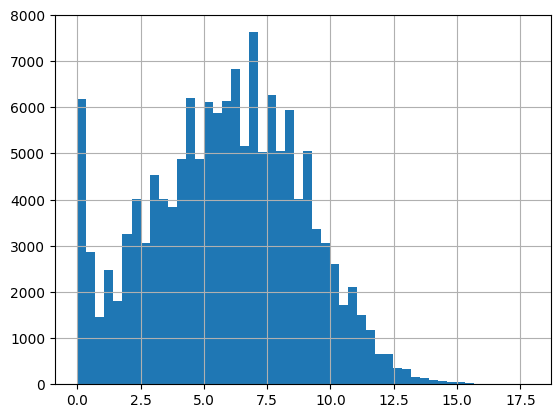

In [67]:


import numpy as np
timeline_df['log_amountUSD'] = np.log1p(timeline_df['amountUSD'])  # log(1 + x)

timeline_df['log_amountUSD'].hist(bins=50)

In [68]:
timeline_df

,amount,amountUSD,hash,id,timestamp,account.id,asset.id,asset.symbol,wallet,action_type,log_amountUSD
0,1.000000e+16,1.780100,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,2019-05-07 01:41:22,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits,1.022487
1,8.000000e+16,14.240800,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,2019-05-07 01:45:11,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,deposits,2.723976
2,4.582921e+21,1562.320140,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,2019-05-07 02:12:05,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x0d8775f648430679a709e98d2b0cb6250d2887ef,BAT,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits,7.354567
3,4.013963e+21,4013.962940,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,2019-05-07 02:12:05,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,DAI,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits,8.297783
4,9.990000e+18,1775.472750,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,2019-05-07 02:41:52,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits,7.482385
...,...,...,...,...,...,...,...,...,...,...,...
140732,7.936690e+07,29.380838,0x40f30264260a3c5df5c0c0aac7d385377cb5fd4c8f2b...,0x40f30264260a3c5df5c0c0aac7d385377cb5fd4c8f2b...,2025-03-13 17:29:23,0x5685464e236944bd2727d3afdb40d121ed747dc6,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,0x5685464e236944bd2727d3afdb40d121ed747dc6,liquidates,3.413812
140733,1.939253e+08,71.287663,0x30ebf3b2df3693113d26647f6a79241451de1ba4e2a9...,0x30ebf3b2df3693113d26647f6a79241451de1ba4e2a9...,2025-03-13 17:46:11,0x4f47aad6b4a0d5d32bd1771eb24bd187a10a34fb,0xdac17f958d2ee523a2206206994597c13d831ec7,USDT,0x4f47aad6b4a0d5d32bd1771eb24bd187a10a34fb,liquidates,4.280653
140734,1.278302e+08,47.257302,0xf5ad48f79a2b7b0aef7bc8296fc53bc7620c56b9863b...,0xf5ad48f79a2b7b0aef7bc8296fc53bc7620c56b9863b...,2025-03-13 18:24:35,0xf3357754413958c4702ce0f02587e94104751e84,0xdac17f958d2ee523a2206206994597c13d831ec7,USDT,0xf3357754413958c4702ce0f02587e94104751e84,liquidates,3.876547
140735,3.221959e+11,15.837574,0x07f426b7f76858f284e4d188cfce95e7387ce180e7ba...,0x07f426b7f76858f284e4d188cfce95e7387ce180e7ba...,2025-03-13 19:30:35,0xfb702e95fa231c5509487a9e99156003985fdb9e,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,0xfb702e95fa231c5509487a9e99156003985fdb9e,liquidates,2.823613


- Removing outliers top 1% and bottom 1%

<Axes: >

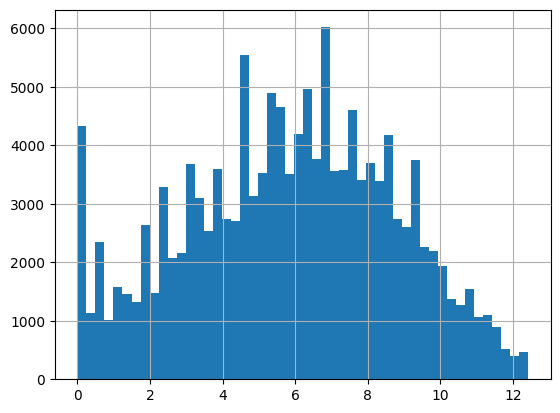

In [ ]:


q_low = timeline_df['log_amountUSD'].quantile(0.01)
q_high = timeline_df['log_amountUSD'].quantile(0.99)

filtered_df = timeline_df[(timeline_df['log_amountUSD'] >= q_low) &
                          (timeline_df['log_amountUSD'] <= q_high)]

filtered_df['log_amountUSD'].hist(bins=50)


In [73]:
timeline_df.head()

,amount,amountUSD,hash,id,timestamp,account.id,asset.id,asset.symbol,wallet,action_type,log_amountUSD
0,1.000000e+16,1.78010,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,2019-05-07 01:41:22,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits,1.022487
1,8.000000e+16,14.24080,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,2019-05-07 01:45:11,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,deposits,2.723976
2,4.582921e+21,1562.32014,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,2019-05-07 02:12:05,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x0d8775f648430679a709e98d2b0cb6250d2887ef,BAT,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits,7.354567
3,4.013963e+21,4013.96294,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,2019-05-07 02:12:05,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0x89d24a6b4ccb1b6faa2625fe562bdd9a23260359,DAI,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits,8.297783
4,9.990000e+18,1775.47275,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,2019-05-07 02:41:52,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,ETH,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,deposits,7.482385


## Feature Extraction ##

1. Activity and Temporal Metrics
- wallet_age_days, tx_frequency_per_day, first_tx_time, last_tx_time
- Captures how long a wallet has been active and how frequently it transacts.

2. Transaction Type Features
- Counts and proportions for deposits, withdraws, borrows, repays, liquidates
- Includes a binary flag has_been_liquidated for classification.

3. Financial Flow Features
- Aggregated log_amountUSD for deposits, withdrawals, borrows, and repays
- Derived metrics: net_position_log_usd, repayment_ratio, collateral_ratio.

4. Time Gap & Interval Analysis
- Extracts: avg_time_between_txs_hours, std_time_between_txs_hours, max_time_gap_days
- Captures behavior consistency and activity spikes/lulls.

5. Asset Diversity & Value Distribution
- unique_assets, unique_asset_symbols to gauge token variety
- Statistical spread of transaction sizes: mean, min, max, std, and tx_value_variation.

In [116]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

def compute_wallet_metrics(timeline_df):
    """
    Calculate comprehensive metrics for each wallet from the processed transaction data
    
    Args:
        timeline_df (pd.DataFrame): DataFrame containing processed transaction data with columns:
            - wallet: wallet address
            - timestamp: transaction timestamp
            - amountUSD: transaction amount in USD
            - action_type: type of transaction (deposits, withdraws, borrows, repays, liquidates)
            - asset.id: asset identifier
            - asset.symbol: asset symbol
            - log_amountUSD: log-transformed amount in USD
        
    Returns:
        pd.DataFrame: DataFrame containing computed metrics for each wallet
    """
    if timeline_df is None:
        raise ValueError("Transaction data not found. Please provide valid transaction data.")
        
    print("Computing wallet metrics...")
    start_time = time.time()
    
    # Get unique wallet addresses
    wallet_addresses = timeline_df['wallet'].unique()
    
    # Initialize storage for wallet metrics
    wallet_metrics = {}
    
    # Process each wallet with progress tracking
    wallet_progress = tqdm(wallet_addresses, desc="Analyzing wallets", unit="wallet")
    
    for wallet in wallet_progress:
        # Update progress description periodically
        if wallet_progress.n % 100 == 0:
            wallet_progress.set_description(f"Analyzing wallet {wallet_progress.n}/{len(wallet_addresses)}")
        
        # Filter transactions for current wallet
        wallet_transactions = timeline_df[timeline_df['wallet'] == wallet]
        
        # Basic transaction metrics
        metrics = {
            'wallet_address': wallet,
            'first_tx_time': wallet_transactions['timestamp'].min(),
            'last_tx_time': wallet_transactions['timestamp'].max(),
            'total_tx_count': len(wallet_transactions),
        }
        
        # Calculate wallet age
        metrics['wallet_age_days'] = (metrics['last_tx_time'] - metrics['first_tx_time']).total_seconds() / (60*60*24)
        
        # Transaction frequency
        if metrics['wallet_age_days'] > 0:
            metrics['tx_frequency_per_day'] = metrics['total_tx_count'] / metrics['wallet_age_days']
        else:
            metrics['tx_frequency_per_day'] = metrics['total_tx_count']
        
        # Transaction type analysis
        tx_type_counts = wallet_transactions['action_type'].value_counts()
        total_txs = len(wallet_transactions)
        
        for tx_type in ['deposits', 'withdraws', 'borrows', 'repays', 'liquidates']:
            count = tx_type_counts.get(tx_type, 0)
            metrics[f'{tx_type}_count'] = count
            metrics[f'{tx_type}_proportion'] = count / total_txs if total_txs > 0 else 0
        
        # Liquidation history
        metrics['has_been_liquidated'] = 1 if metrics['liquidates_count'] > 0 else 0
        
        # Deposit and withdrawal analysis
        deposits = wallet_transactions[wallet_transactions['action_type'] == 'deposits']
        withdraws = wallet_transactions[wallet_transactions['action_type'] == 'withdraws']
        
        # Financial metrics using log_amountUSD
        metrics['total_deposited_log_usd'] = deposits['log_amountUSD'].sum() if not deposits.empty else 0
        metrics['total_withdrawn_log_usd'] = withdraws['log_amountUSD'].sum() if not withdraws.empty else 0
        metrics['net_position_log_usd'] = metrics['total_deposited_log_usd'] - metrics['total_withdrawn_log_usd']
        
        # Borrowing analysis
        borrows = wallet_transactions[wallet_transactions['action_type'] == 'borrows']
        repays = wallet_transactions[wallet_transactions['action_type'] == 'repays']
        
        metrics['total_borrowed_log_usd'] = borrows['log_amountUSD'].sum() if not borrows.empty else 0
        metrics['total_repaid_log_usd'] = repays['log_amountUSD'].sum() if not repays.empty else 0
        
        # Repayment analysis
        if metrics['total_borrowed_log_usd'] > 0:
            metrics['repayment_ratio'] = metrics['total_repaid_log_usd'] / metrics['total_borrowed_log_usd']
        else:
            metrics['repayment_ratio'] = 1.0
        
        # Transaction timing analysis
        if len(wallet_transactions) > 1:
            tx_times = wallet_transactions['timestamp'].sort_values()
            time_intervals = tx_times.diff().dropna()
            metrics['avg_time_between_txs_hours'] = time_intervals.mean().total_seconds() / 3600
            metrics['std_time_between_txs_hours'] = time_intervals.std().total_seconds() / 3600 if len(time_intervals) > 1 else 0
            metrics['max_time_gap_days'] = time_intervals.max().total_seconds() / (24*3600)
        else:
            metrics['avg_time_between_txs_hours'] = 0
            metrics['std_time_between_txs_hours'] = 0
            metrics['max_time_gap_days'] = 0
        
        # Asset diversity
        metrics['unique_assets'] = wallet_transactions['asset.id'].nunique()
        metrics['unique_asset_symbols'] = wallet_transactions['asset.symbol'].nunique()
        
        # Transaction value analysis using log_amountUSD
        if 'log_amountUSD' in wallet_transactions.columns:
            metrics['avg_tx_log_usd'] = wallet_transactions['log_amountUSD'].mean()
            metrics['max_tx_log_usd'] = wallet_transactions['log_amountUSD'].max()
            metrics['min_tx_log_usd'] = wallet_transactions['log_amountUSD'].min()
            metrics['std_tx_log_usd'] = wallet_transactions['log_amountUSD'].std() if len(wallet_transactions) > 1 else 0
            metrics['tx_value_variation'] = metrics['std_tx_log_usd'] / metrics['avg_tx_log_usd'] if metrics['avg_tx_log_usd'] > 0 else 0
        
        # Collateral analysis
        if metrics['total_borrowed_log_usd'] > 0:
            metrics['collateral_ratio'] = metrics['total_deposited_log_usd'] / metrics['total_borrowed_log_usd']
        else:
            metrics['collateral_ratio'] = float('inf')
        
        # Store metrics for this wallet
        wallet_metrics[wallet] = metrics
        
        # Update progress stats periodically
        if wallet_progress.n % 500 == 0:
            wallet_progress.set_postfix(elapsed=f"{time.time() - start_time:.1f}s")
    
    # Convert to DataFrame
    wallet_metrics_df = pd.DataFrame(list(wallet_metrics.values()))
    elapsed = time.time() - start_time
    print(f"Computed {len(wallet_metrics_df.columns)} metrics for {len(wallet_metrics_df)} wallets in {elapsed:.2f} seconds")
    
    return wallet_metrics_df

In [115]:
feature_df = compute_wallet_metrics(timeline_df)
feature_df.head()


Computing wallet metrics...


Analyzing wallet 16900/17231: 100%|██████████| 17231/17231 [06:57<00:00, 41.27wallet/s, elapsed=399.3s]


Computed 34 metrics for 17231 wallets in 418.34 seconds


,wallet_address,first_tx_time,last_tx_time,total_tx_count,wallet_age_days,tx_frequency_per_day,deposits_count,deposits_proportion,withdraws_count,withdraws_proportion,...,std_time_between_txs_hours,max_time_gap_days,unique_assets,unique_asset_symbols,avg_tx_log_usd,max_tx_log_usd,min_tx_log_usd,std_tx_log_usd,tx_value_variation,collateral_ratio
0,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,2019-05-07 01:41:22,2019-09-23 23:27:04,149,139.906736,1.064995,30,0.201342,39,0.261745,...,59.987062,20.149757,7,7,4.420416,8.901924,0.000000,2.933940,0.663725,1.291967
1,0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f,2019-05-07 01:45:11,2019-11-28 00:32:20,6,204.949410,0.029276,1,0.166667,1,0.166667,...,1352.101554,134.121447,3,3,0.969475,2.723976,0.092630,1.014383,1.046322,2.293428
2,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,2019-05-07 02:47:52,2019-07-16 21:29:53,8,70.779178,0.113028,7,0.875000,0,0.000000,...,633.983536,70.014734,7,7,0.249614,1.078789,0.051819,0.337480,1.352006,37.536537
3,0x2025a9196d6fa1011080845c6877f6460cdb302b,2019-05-07 05:27:37,2019-10-14 01:09:21,8,159.820648,0.050056,6,0.750000,2,0.250000,...,784.967536,74.662442,5,5,4.526819,8.244175,0.688102,2.924941,0.646136,inf
4,0x6316ff9d2c96b6b122e0dd632ab5831e0bf5bd10,2019-05-07 05:44:18,2019-08-02 10:16:37,8,87.189109,0.091755,3,0.375000,1,0.125000,...,368.437175,37.106042,3,3,8.815990,10.379733,2.227316,2.762517,0.313353,0.989075


- Score Initialization and Structure. Each wallet starts with a base score of 100, from which penalties or rewards are applied across 5 behavioral categories totaling 100 points.
- Financial Health (30 pts) Penalties are applied for low repay_ratio, high liquidation_frequency, and poor collateral_utilization_ratio, reflecting trustworthiness in managing loans and collateral.
- Activity Patterns (25 pts) Penalizes erratic behaviors like abnormal transaction_frequency_per_day, high transaction_burstiness, and excessive proportion_small_txns to detect suspicious or inconsistent usage.
- Risk Indicators (20 pts) Factors like early time_to_first_liquidation and high withdraw_after_borrow_ratio signal risky financial conduct and reduce the score.
- Protocol Engagement & Stability (25 pts) Rewards long-term engagement (protocol_loyalty_weeks, num_cycles) and penalizes negative net_flow or extreme borrow-to-deposit ratios, promoting stable and committed user behavior.

In [117]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os

def calculate_wallet_scores(features_df, output_dir='results'):
    """
    Calculate credit scores for wallets based on engineered features and save results to CSV
    
    Args:
        features_df (pd.DataFrame): DataFrame containing wallet features
        output_dir (str): Directory to save the results
        
    Returns:
        pd.DataFrame: DataFrame containing the calculated scores
    """
    if features_df is None:
        raise ValueError("Features DataFrame not provided. Please provide valid features data.")
        
    print("Calculating wallet scores...")
    start_time = time.time()
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Copy the feature DataFrame to avoid modifying the original
    df = features_df.copy()
    
    # Filter out wallets with very limited activity (e.g., single transaction)
    df = df[df['total_tx_count'] > 1].copy()
    
    # Define key scoring metrics
    score_components = {
        # Activity Consistency (higher is better)
        'wallet_longevity': lambda x: min(x['wallet_age_days'] / 365, 2),  # Cap at 2 years
        'tx_frequency': lambda x: min(x['tx_frequency_per_day'], 5) / 5,  # Normalize to [0,1]
        'time_consistency': lambda x: 1 - min(x['std_time_between_txs_hours'] / 168, 1),  # Lower variation is better
        
        # Repayment Behavior (higher is better)
        'repayment_efficiency': lambda x: min(x['repayment_ratio'], 1),  # Cap at 1
        'collateral_health': lambda x: min(x['collateral_ratio'], 2) / 2,  # Normalize to [0,1]
        
        # Liquidation History (lower is better)
        'liquidation_penalty': lambda x: -x['has_been_liquidated'] * 0.5,  # 50% penalty for liquidation
        
        # Transaction Pattern (diversity is good, extreme volatility is bad)
        'asset_diversity': lambda x: min(x['unique_assets'] / 3, 1),  # Normalize to [0,1]
        'tx_value_volatility': lambda x: -min(x['tx_value_variation'] / 10, 1),  # Penalize high volatility
        
        # Utilization Patterns
        'borrow_activity': lambda x: 0.5 if x['borrows_count'] > 0 else 0,  # Bonus for using borrows
        'healthy_usage': lambda x: 0.5 if (x['deposits_count'] > 0 and 
                                          x['withdraws_count'] > 0 and 
                                          x['borrows_count'] > 0 and 
                                          x['repays_count'] > 0) else 0  # Bonus for using all features
    }
    
    # Calculate the raw score for each component with progress bar
    score_pbar = tqdm(score_components.items(), desc="Computing score components", unit="component")
    for component, score_func in score_pbar:
        score_pbar.set_description(f"Computing {component}")
        df[f'score_{component}'] = df.apply(score_func, axis=1)
    
    # Calculate overall raw score (sum of all components)
    score_columns = [f'score_{component}' for component in score_components.keys()]
    df['raw_score'] = df[score_columns].sum(axis=1)
    
    # Normalize the raw score to 0-100
    min_possible_score = -0.5  # The minimum possible score (with liquidation penalty)
    max_possible_score = sum([1, 1, 1, 1, 1, 0, 1, 0, 0.5, 0.5])  # Max possible from all positive components
    
    # Apply normalization
    df['normalized_score'] = ((df['raw_score'] - min_possible_score) / 
                             (max_possible_score - min_possible_score)) * 100
    
    # Ensure scores are within bounds
    df['final_score'] = np.clip(df['normalized_score'], 0, 100)
    
    # Create final results DataFrame
    results_df = df[['wallet_address', 'final_score'] + score_columns + ['raw_score', 'normalized_score']]
    
    # Save results to CSV
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    output_file = os.path.join(output_dir, f'wallet_scores_{timestamp}.csv')
    results_df.to_csv(output_file, index=False)
    
    elapsed = time.time() - start_time
    print(f"Calculated scores for {len(results_df)} wallets in {elapsed:.2f} seconds")
    print(f"Results saved to: {output_file}")
    
    return results_df 
    

In [119]:
wallet_scores = calculate_wallet_scores(feature_df, output_dir='credit_scores')

Calculating wallet scores...


Computing score components:   0%|          | 0/10 [00:00<?, ?component/s]

Computing healthy_usage: 100%|██████████| 10/10 [00:07<00:00,  1.40component/s]      


Calculated scores for 12046 wallets in 7.52 seconds
Results saved to: credit_scores\wallet_scores_20250505_210739.csv


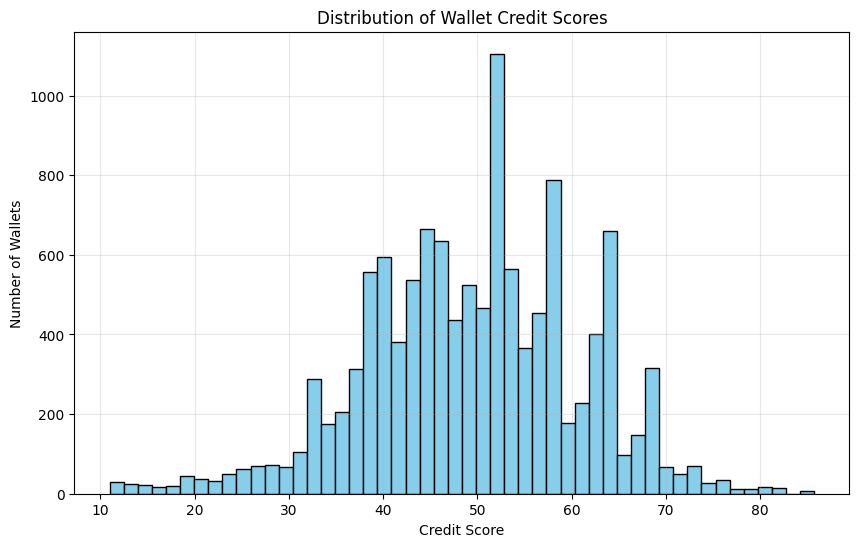

In [128]:
comp2 = pd.read_csv('credit_scores/wallet_scores_20250505_210739.csv')
plt.figure(figsize=(10, 6))
plt.hist(comp2['final_score'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.title('Distribution of Wallet Credit Scores')
plt.grid(True, alpha=0.3)
plt.show()